# Detect anomalies in time series via tsmoothie

> Notes from [Real-Time Time Series Anomaly Detection](https://towardsdatascience.com/real-time-time-series-anomaly-detection-981cf1e1ca13)

## Anomalies

**Anomalies can be anything _different_ or _abnormal_ that deviates substantially from other data in the sample or historical data**.

Anomalies are often divided into _point_ and _pattern_ anomalies. Point anomalies are single instances of something abnormal, while pattern anomalies represent clusters of data that create a pattern that is very different from normal.

Pattern anomalies are more difficult to detect because we must first be able to define a normal pattern, and then we could need more data to be able to classify that this pattern is anomalous compared to historical activity.

### Point Anomalies

Detecting points that deviate much from others which arouses suspicions that such "outliers" were generated by a different mechanism.

Two different algorithms are used: a **convolutional smoother** and an **exponential smoother**. Both smooth the received signals using a sliding window approach. The convolution approach uses a discrete linear convolution while the exponential one uses an exponentially weighted convolution.

**Convolution** is a mathematical operation that could be described as the integral of the product of two sequences: the raw signal and the weights. The convolutional smoother uses weights generated using predefined windows function (`linear`, `hanning`, `hamming`, `bartlett`, `blackman`). In the case of linear type, the weights are all the same and equal to one. This makes the operation equal to a moving average.

The **exponential smoother** uses weights generated with an exponential function. As result, the most recent observations weight the most when computing the smoothing.

[..]

When a new value is collected, the smoothing is computed. The differences between the real observations and the corresponding smoothed values are known as _residuals_. We use them to define the _outliers_ or _anomalies_ as the points where the real observations exceed the residuals’ confidence bands.

### Pattern Anomalies

The aim here is to detect a continuous set of data points that are collectively anomalous even though the individual points may or may not be point anomalies. When we are looking for pattern anomalies the underlying assumption is that the raw data must show a pattern. This is the case, for example, of seasonal time series.

Seasonality in time series is commonly observed in a lot of data. Studying the seasonal component is critical for effective anomaly detection. In this regard, a **key challenge** is *how to determine the seasonal period and separate it from trends*. **Seasonal-Trend-Decomposition** is one of the commonly used approaches for detecting seasonal and trend components. **Convolution filtering**, **LOWESS**, or **natural-cubic-spline** are the techniques used by `tsmoothie` to detect a trend component. While seasonal patterns are detected using a mean aggregation in the periods. From the union of the extracted trend and the observed seasonalities, we can build an hypothetical time series of smoothed values.

Seasonal series with trends are taken into account to detect pattern anomalies using a decomposition smoother. In the first case, our aim is to detect observations that don’t respect the studied pattern present so far in the data. For the majority, this is the case of observations that break the seasonality pattern. In the second case, we introduce a shift in some intervals. We want to see if this is detected as a drastic change that can alter the trend and so be pointed out as anomalous.

### Relevant Questions & Answers

- https://stats.stackexchange.com/questions/120433/outlier-detection-in-time-series-how-to-reduce-false-positives

## Programmatic preamble

In [1]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from celluloid import Camera
from collections import defaultdict
from functools import partial
from tqdm import tqdm

from tsmoothie.utils_func import sim_randomwalk, sim_seasonal_data
from tsmoothie.smoother import *

### Helper functions

In [2]:
def plot_history(ax, i, is_anomaly, window_len, color='blue', **pltargs):
    
    posrange = np.arange(0,i)
    
    ax.fill_between(posrange[window_len:], 
                    pltargs['low'][1:], pltargs['up'][1:], 
                    color=color, alpha=0.2)
    if is_anomaly:
        ax.scatter(i-1, pltargs['original'][-1], c='red')
    else:
        ax.scatter(i-1, pltargs['original'][-1], c='black')
    ax.scatter(i-1, pltargs['smooth'][-1], c=color)
    
    ax.plot(posrange, pltargs['original'][1:], '.k')
    ax.plot(posrange[window_len:], 
            pltargs['smooth'][1:], color=color, linewidth=3)
    
    if 'ano_id' in pltargs.keys():
        if pltargs['ano_id'].sum()>0:
            not_zeros = pltargs['ano_id'][pltargs['ano_id']!=0] -1
            ax.scatter(not_zeros, pltargs['original'][1:][not_zeros], 
                       c='red', alpha=1.)

#### Function for detecting outliers via convolutional smoothing

In [3]:
# %%time

def detect_outliers_via_convolution(
    data,
    n_sigma=3,
    window_len=24,
    # series=None,
):
    """
    """
    n_series, timesteps = data.shape
    
    # if not series:
        # series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))
    series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))

    for i in tqdm(range(timesteps+1), total=(timesteps+1)):
        
        if i > window_len:
        
            # smooth time series first ?
            smoother = ConvolutionSmoother(window_len=window_len, window_type='ones')
            smoother.smooth(series['original'][:,-window_len:])
            series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 
    
            # 1
            
            # split in upper and lower stacks based on smoothed series and 'n_sigma'
            _low, _up = smoother.get_intervals(
                'sigma_interval',
                n_sigma=n_sigma
            )
            series['low'] = np.hstack([series['low'], _low[:,[-1]]])
            series['up'] = np.hstack([series['up'], _up[:,[-1]]])
            
            # detect anomalies
            is_anomaly = np.logical_or(
                series['original'][:,-1] > series['up'][:,-1], 
                series['original'][:,-1] < series['low'][:,-1]
            ).reshape(-1,1)
            
            if is_anomaly.any():
                series['ano_id'] = np.hstack(
                    [series['ano_id'],
                     is_anomaly*i]
                ).astype(int)
                
            
#             # 2
            
#             # split in upper and lower stacks based on smoothed series and 'n_sigma_2'
#             _low_2, _up_2 = smoother.get_intervals(
#                 'sigma_interval',
#                 n_sigma=n_sigma_2
#             )
#             series['low_2'] = np.hstack([series['low_2'], _low_2[:,[-1]]])
#             series['up_2'] = np.hstack([series['up_2'], _up_2[:,[-1]]])
    
#             # detect anomalies
#             is_anomaly_2 = np.logical_or(
#                 series['original'][:,-1] > series['up_2'][:,-1], 
#                 series['original'][:,-1] < series['low_2'][:,-1]
#             ).reshape(-1,1)
            
#             if is_anomaly_2.any():
#                 series['ano_id_2'] = np.hstack(
#                     [series['ano_id_2'],
#                      is_anomaly_2*i]
#                 ).astype(int)
            
            # for s in range(n_series):
            #     pltargs = {k:v[s,:] for k,v in series.items()}
            #     plot_history(axes[s], i, is_anomaly[s], window_len, 
            #                  **pltargs)
            # camera.snap()
            
        if i >= timesteps:
            continue
        
        series['original'] = np.hstack(
            [series['original'],
             data[:,[i]]]
        )
    
    return series

#### Function for plotting detected outliers via convolutional smoothing

In [4]:
def plot_series(series):
    """
    """
    fig = plt.figure(figsize=(18,10))
    axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]
    plt.style.use('seaborn-v0_8-whitegrid')
    
    for i, ax in enumerate(axes):
        
        # plot original time series
        # ax.plot(
        #     series['original'][i,1:],
        #     '.k',
        #     label='Original data',
        #     ms='2',
        # )
        ax.plot(
            series['original'][i,1:],
            series['original'][i,1:],  #'.k',
            color='grey',
            linestyle='dotted',
            label='Original data',
            ms='80',
        )
        
        # build + plot "positional" (?) range
        posrange = np.arange(window_len,timesteps)
        ax.plot(
            posrange,
            series['smooth'][i,1:],
            c='blue',
            alpha=0.5,
            linewidth=2,
            label='Smoothed data (convolution)',
        )
        ax.fill_between(
            posrange, 
            series['low'][i,1:],
            series['up'][i,1:], 
            color='blue',
            alpha=0.1
        )
    
        # ano_id_2 = series['ano_id_2'][i][series['ano_id_2'][i] != 0] -1
        # if len(ano_id_2)>0:
        #     ax.scatter(
        #         ano_id_2,
        #         series['original'][i,1:][ano_id_2],
        #         c='blue',
        #         alpha=1.,
        #         label=f'Sigma = {n_sigma_2}',
        #         s=300,
        #     )
    
        ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
        if len(ano_id)>0:
            ax.scatter(
                ano_id,
                series['original'][i,1:][ano_id],
                # marker='d',
                c='red',
                alpha=1.,
                label=f'Sigma = {n_sigma}',
                s=80,
            )
    
    plt.suptitle('Temperature 2m, 2013', fontsize=18)
    plt.title('Example over some location', fontsize=16)
    plt.ylabel('Kelvin', fontsize=14)
    plt.xlabel('Index (instead of dates)', fontsize=14)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.legend(fontsize=14)
    plt.show()

## Read data

In [5]:
path_to_data = Path('../data')
t2m_some_location = xr.open_dataarray(path_to_data/'era5_and_land_2m_temperature_longitude_1643_latitude_4347.nc')
d2m_location_3 = xr.open_dataarray(path_to_data/'dewpoint_temperature_location_3_pvgis52_patched.nc')
rh_location_1 = xr.open_dataarray(path_to_data/'relative_humidity_location_1_pvgis52_patched.nc')
ws_location_3 = xr.open_dataarray(path_to_data/'wind_speed_location_3_pvgis52_patched.nc')

# Anomalies in patched ERA5 & Land datasets

## Convolutional smoother

### Temperature 2m

#### Sliding window and Sigma parameters

In [6]:
window_len = 24
n_sigma = 3.5
n_sigma_2 = 4
print(f'Window length : {window_len}\nn_sigma : {n_sigma}\nn_sigma_2 : {n_sigma_2}')

Window length : 24
n_sigma : 3.5
n_sigma_2 : 4


#### Prepare data

The input data set is:

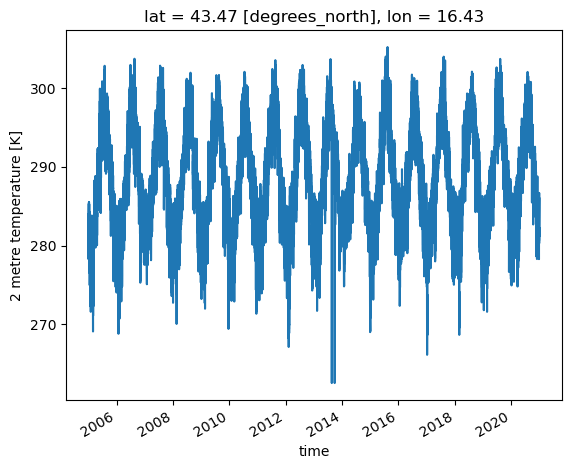

In [7]:
plt.title('Temperature 2m')
plt.ylabel('Kelvin')
t2m_some_location.plot()
np.set_printoptions(False)
plt.show()

This time series obviously contains two erroneous data points, likely artefacts introduced during the patching process of ERA5 and ERA5-Land data.

In order to make the data work with the `tsmoothie` package, we convert the xarray to a regular NumPy array.

In [8]:
n_series = 1
timesteps = t2m_some_location.size
t2m_some_location_array = t2m_some_location.to_numpy().reshape(n_series, timesteps)
data = np.array(t2m_some_location_array, copy=True)

print(f'Shape of array : {data.shape}\nNumber of time series : {n_series}\nTime steps : {timesteps}')

Shape of array : (1, 140256)
Number of time series : 1
Time steps : 140256


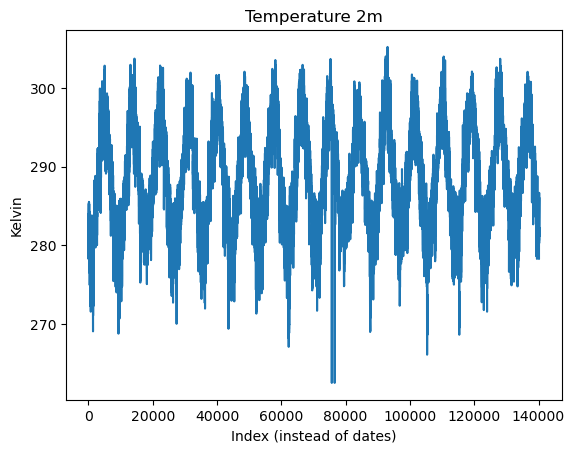

In [9]:
plt.title('Temperature 2m')
plt.ylabel('Kelvin')
plt.xlabel('Index (instead of dates)')
plt.plot(data.T)
np.set_printoptions(False)
plt.show()

#### Detect outliers

In [10]:
# This is to create a GIF!

# fig = plt.figure(figsize=(18,10))
# camera = Camera(fig)
# axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

In [11]:
# %%time
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))
for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i > window_len:
    
        # smooth time series first ?
        smoother = ConvolutionSmoother(window_len=window_len, window_type='ones')
        smoother.smooth(series['original'][:,-window_len:])
        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        # 1
        
        # split in upper and lower stacks based on smoothed series and 'n_sigma'
        _low, _up = smoother.get_intervals(
            'sigma_interval',
            n_sigma=n_sigma
        )
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])
        
        # detect anomalies
        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack(
                [series['ano_id'],
                 is_anomaly*i]
            ).astype(int)
            
        
        # 2
        
        # split in upper and lower stacks based on smoothed series and 'n_sigma_2'
        _low_2, _up_2 = smoother.get_intervals(
            'sigma_interval',
            n_sigma=n_sigma_2
        )
        series['low_2'] = np.hstack([series['low_2'], _low_2[:,[-1]]])
        series['up_2'] = np.hstack([series['up_2'], _up_2[:,[-1]]])

        # detect anomalies
        is_anomaly_2 = np.logical_or(
            series['original'][:,-1] > series['up_2'][:,-1], 
            series['original'][:,-1] < series['low_2'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly_2.any():
            series['ano_id_2'] = np.hstack(
                [series['ano_id_2'],
                 is_anomaly_2*i]
            ).astype(int)
        
        # for s in range(n_series):
        #     pltargs = {k:v[s,:] for k,v in series.items()}
        #     plot_history(axes[s], i, is_anomaly[s], window_len, 
        #                  **pltargs)
        # camera.snap()
        
    if i >= timesteps:
        continue
    
    series['original'] = np.hstack(
        [series['original'],
         data[:,[i]]]
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140257/140257 [01:44<00:00, 1344.84it/s]


In [12]:
# print('CREATING GIF...')  # it may take a few seconds
# camera._photos = [camera._photos[-1]] + camera._photos
# animation = camera.animate()
# animation.save('animation1.gif')
# plt.close(fig)
# print('DONE')

#### Result

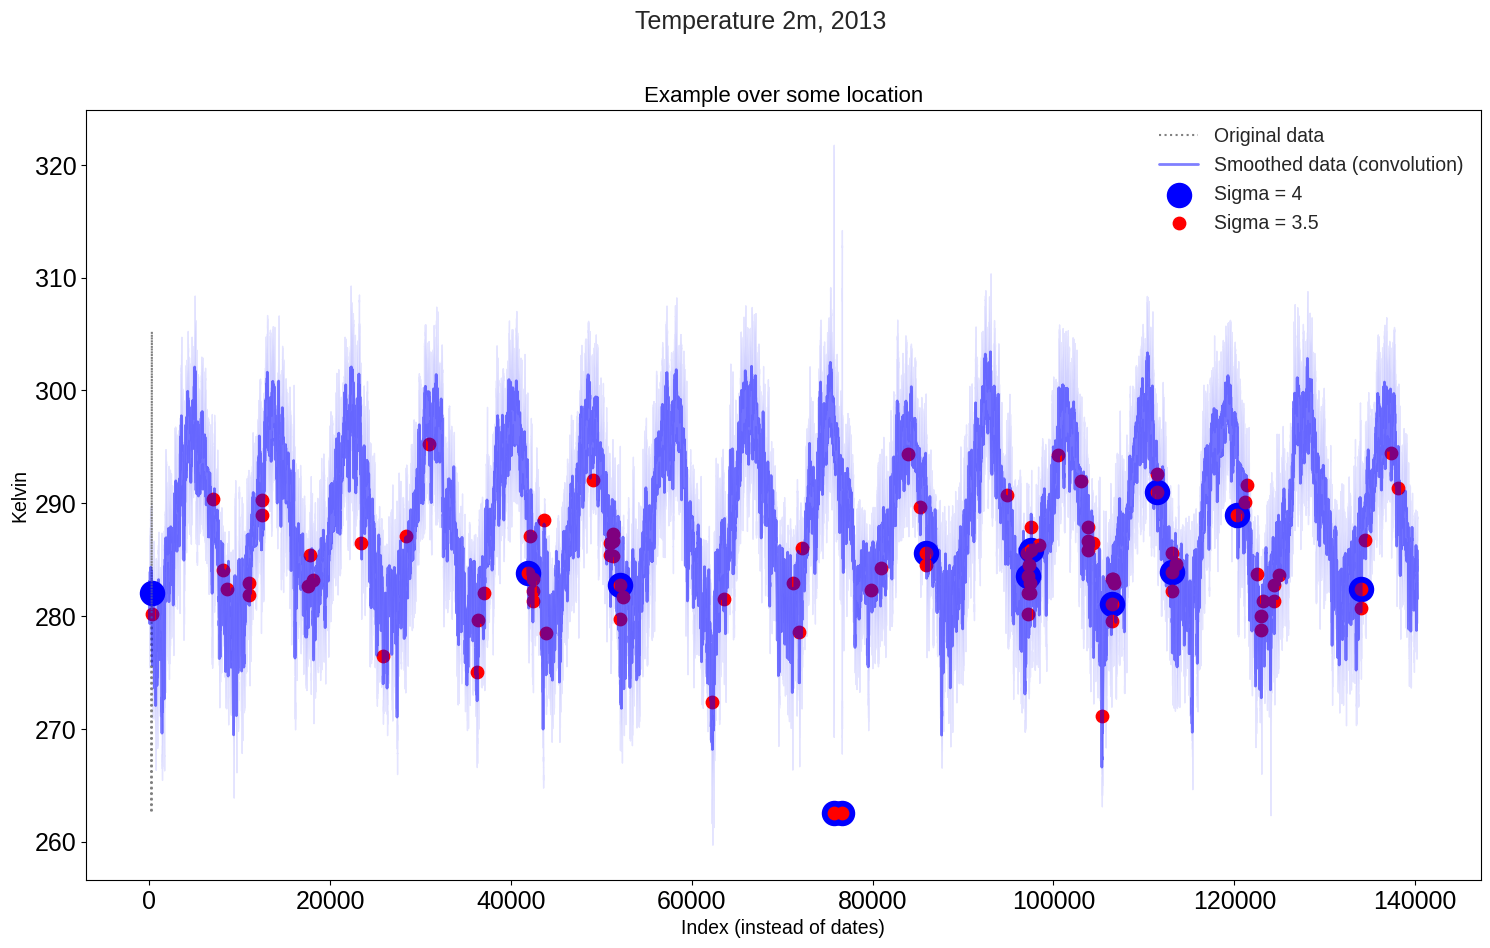

In [13]:
fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]
plt.style.use('seaborn-v0_8-whitegrid')

for i, ax in enumerate(axes):
    
    # plot original time series
    # ax.plot(
    #     series['original'][i,1:],
    #     '.k',
    #     label='Original data',
    #     ms='2',
    # )
    ax.plot(
        series['original'][i,1:],
        series['original'][i,1:],  #'.k',
        color='grey',
        linestyle='dotted',
        label='Original data',
        ms='80',
    )
    
    # build + plot "positional" (?) range
    posrange = np.arange(window_len,timesteps)
    ax.plot(
        posrange,
        series['smooth'][i,1:],
        c='blue',
        alpha=0.5,
        linewidth=2,
        label='Smoothed data (convolution)',
    )
    ax.fill_between(
        posrange, 
        series['low'][i,1:],
        series['up'][i,1:], 
        color='blue',
        alpha=0.1
    )

    ano_id_2 = series['ano_id_2'][i][series['ano_id_2'][i] != 0] -1
    if len(ano_id_2)>0:
        ax.scatter(
            ano_id_2,
            series['original'][i,1:][ano_id_2],
            c='blue',
            alpha=1.,
            label=f'Sigma = {n_sigma_2}',
            s=300,
        )

    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    if len(ano_id)>0:
        ax.scatter(
            ano_id,
            series['original'][i,1:][ano_id],
            # marker='d',
            c='red',
            alpha=1.,
            label=f'Sigma = {n_sigma}',
            s=80,
        )

plt.suptitle('Temperature 2m, 2013', fontsize=18)
plt.title('Example over some location', fontsize=16)
plt.ylabel('Kelvin', fontsize=14)
plt.xlabel('Index (instead of dates)', fontsize=14)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=14)
plt.show()

### Relative humidity

#### Sliding window and Sigma parameters

In [14]:
window_len = 24
n_sigma = 4
n_sigma_2 = 4.5
print(f'Window length : {window_len}\nn_sigma : {n_sigma}\nn_sigma_2 : {n_sigma_2}')

Window length : 24
n_sigma : 4
n_sigma_2 : 4.5


#### Prepare data

The input data set is:

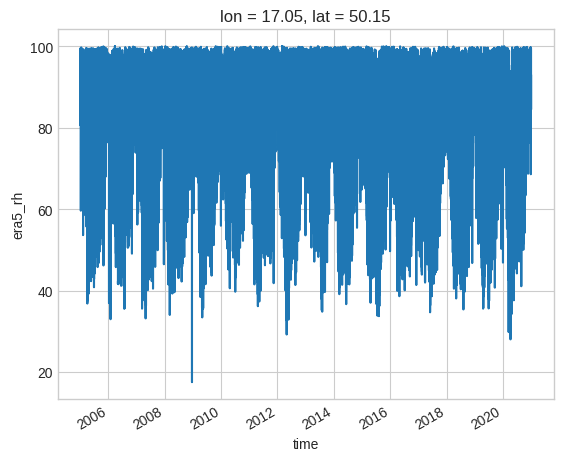

In [15]:
plt.title('Relative humidity')
plt.ylabel('%')
rh_location_1.plot()
np.set_printoptions(False)
plt.show()

This time series obviously contains two erroneous data points, likely artefacts introduced during the patching process of ERA5 and ERA5-Land data.

In order to make the data work with the `tsmoothie` package, we convert the xarray to a regular NumPy array.

In [16]:
n_series = 1
timesteps = rh_location_1.time.size
rh_location_1_array = rh_location_1.to_numpy().reshape(n_series, timesteps)
data = np.array(rh_location_1_array, copy=True)

print(f'Shape of array : {data.shape}\nNumber of time series : {n_series}\nTime steps : {timesteps}')

Shape of array : (1, 140256)
Number of time series : 1
Time steps : 140256


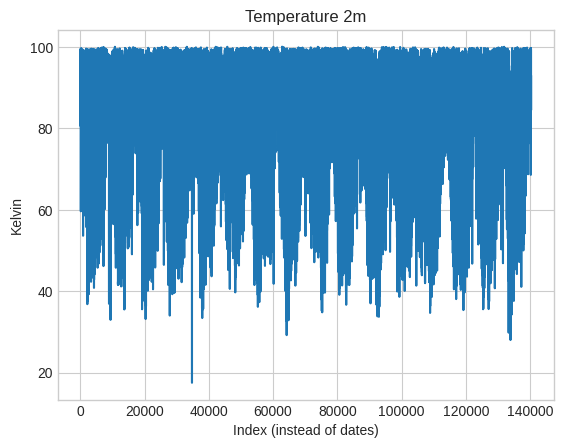

In [17]:
plt.title('Temperature 2m')
plt.ylabel('Kelvin')
plt.xlabel('Index (instead of dates)')
plt.plot(data.T)
np.set_printoptions(False)
plt.show()

#### Detect outliers

In [18]:
# This is to create a GIF!

# fig = plt.figure(figsize=(18,10))
# camera = Camera(fig)
# axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

In [19]:
%%time
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))
for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i > window_len:
    
        # smooth time series first ?
        smoother = ConvolutionSmoother(window_len=window_len, window_type='ones')
        smoother.smooth(series['original'][:,-window_len:])
        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        # 1
        
        # split in upper and lower stacks based on smoothed series and 'n_sigma'
        _low, _up = smoother.get_intervals(
            'sigma_interval',
            n_sigma=n_sigma
        )
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])
        
        # detect anomalies
        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack(
                [series['ano_id'],
                 is_anomaly*i]
            ).astype(int)
            
        
        # 2
        
        # split in upper and lower stacks based on smoothed series and 'n_sigma_2'
        _low_2, _up_2 = smoother.get_intervals(
            'sigma_interval',
            n_sigma=n_sigma_2
        )
        series['low_2'] = np.hstack([series['low_2'], _low_2[:,[-1]]])
        series['up_2'] = np.hstack([series['up_2'], _up_2[:,[-1]]])

        # detect anomalies
        is_anomaly_2 = np.logical_or(
            series['original'][:,-1] > series['up_2'][:,-1], 
            series['original'][:,-1] < series['low_2'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly_2.any():
            series['ano_id_2'] = np.hstack(
                [series['ano_id_2'],
                 is_anomaly_2*i]
            ).astype(int)
        
        # for s in range(n_series):
        #     pltargs = {k:v[s,:] for k,v in series.items()}
        #     plot_history(axes[s], i, is_anomaly[s], window_len, 
        #                  **pltargs)
        # camera.snap()
        
    if i >= timesteps:
        continue
    
    series['original'] = np.hstack(
        [series['original'],
         data[:,[i]]]
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140257/140257 [01:47<00:00, 1308.83it/s]

CPU times: user 1min 47s, sys: 193 ms, total: 1min 47s
Wall time: 1min 47s


In [20]:
# print('CREATING GIF...')  # it may take a few seconds
# camera._photos = [camera._photos[-1]] + camera._photos
# animation = camera.animate()
# animation.save('animation1.gif')
# plt.close(fig)
# print('DONE')

#### Result

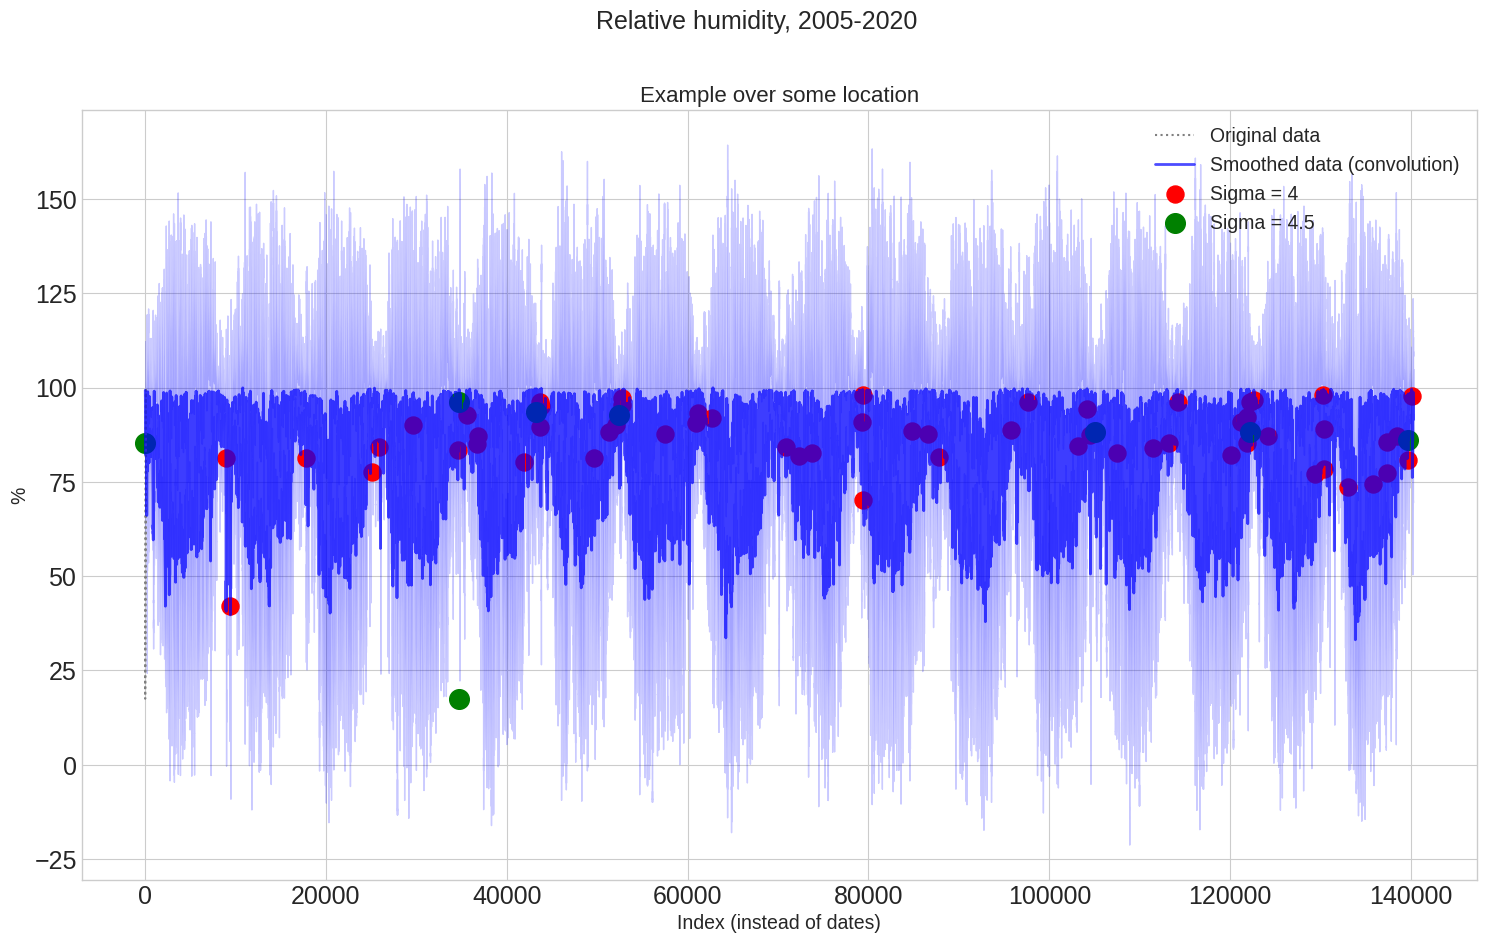

In [21]:
fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i, ax in enumerate(axes):
    
    # plot original time series
    # ax.plot(
    #     series['original'][i,1:],
    #     '.k',
    #     label='Original data',
    #     ms='2',
    # )
    ax.plot(
        series['original'][i,1:],
        series['original'][i,1:],  #'.k',
        color='grey',
        linestyle='dotted',
        label='Original data',
        ms='80',
    )
    
    # build + plot "positional" (?) range
    posrange = np.arange(window_len,timesteps)
    ax.plot(
        posrange,
        series['smooth'][i,1:],
        c='blue',
        linewidth=2,
        label='Smoothed data (convolution)',
        alpha=0.7
    )
    ax.fill_between(
        posrange, 
        series['low'][i,1:],
        series['up'][i,1:], 
        color='blue',
        alpha=0.2
    )

    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    if len(ano_id)>0:
        ax.scatter(
            ano_id,
            series['original'][i,1:][ano_id],
            c='red',
            alpha=1.,
            label=f'Sigma = {n_sigma}',
            s=150,
        )

    ano_id_2 = series['ano_id_2'][i][series['ano_id_2'][i] != 0] -1
    if len(ano_id)>0:
        ax.scatter(
            ano_id_2,
            series['original'][i,1:][ano_id_2],
            c='green',
            alpha=1.,
            label=f'Sigma = {n_sigma_2}',
            s=200,
        )

plt.suptitle('Relative humidity, 2005-2020', fontsize=18)
plt.title('Example over some location', fontsize=16)
plt.ylabel('%', fontsize=14)
plt.xlabel('Index (instead of dates)', fontsize=14)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=14)
plt.show()

### Dewpoint temperature 2m

#### Sliding window and Sigma parameters

In [22]:
window_len = 24
n_sigma = 4.5
n_sigma_2 = 4.7
print(f'Window length : {window_len}\nn_sigma : {n_sigma}\nn_sigma_2 : {n_sigma_2}')

Window length : 24
n_sigma : 4.5
n_sigma_2 : 4.7


#### Prepare data

The input data set is:

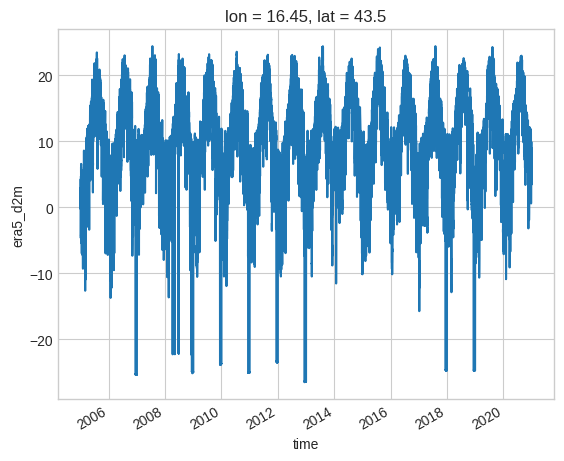

In [23]:
plt.title('Dewpoint temperature 2m')
plt.ylabel('Kelvin')
d2m_location_3.plot()
np.set_printoptions(False)
plt.show()

This time series obviously contains two erroneous data points, likely artefacts introduced during the patching process of ERA5 and ERA5-Land data.

In order to make the data work with the `tsmoothie` package, we convert the xarray to a regular NumPy array.

In [24]:
n_series = 1
timesteps = d2m_location_3.time.size
d2m_location_3_array = d2m_location_3.to_numpy().reshape(1, timesteps)
data = np.array(d2m_location_3_array, copy=True)

print(f'Shape of array : {data.shape}\nNumber of time series : {n_series}\nTime steps : {timesteps}')

Shape of array : (1, 140256)
Number of time series : 1
Time steps : 140256


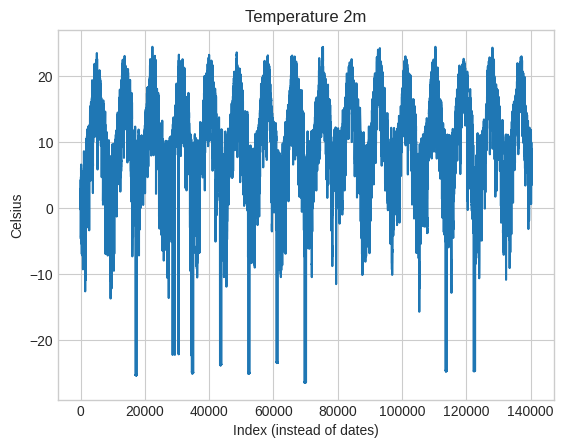

In [25]:
plt.title('Temperature 2m')
plt.ylabel('Celsius')
plt.xlabel('Index (instead of dates)')
plt.plot(data.T)
np.set_printoptions(False)
plt.show()

#### Detect outliers

In [26]:
# This is to create a GIF!

# fig = plt.figure(figsize=(18,10))
# camera = Camera(fig)
# axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

In [27]:
%%time
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))
for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i > window_len:
    
        # smooth time series first ?
        smoother = ConvolutionSmoother(window_len=window_len, window_type='ones')
        smoother.smooth(series['original'][:,-window_len:])
        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        # 1
        
        # split in upper and lower stacks based on smoothed series and 'n_sigma'
        _low, _up = smoother.get_intervals(
            'sigma_interval',
            n_sigma=n_sigma
        )
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])
        
        # detect anomalies
        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack(
                [series['ano_id'],
                 is_anomaly*i]
            ).astype(int)
            
        
        # 2
        
        # split in upper and lower stacks based on smoothed series and 'n_sigma_2'
        _low_2, _up_2 = smoother.get_intervals(
            'sigma_interval',
            n_sigma=n_sigma_2
        )
        series['low_2'] = np.hstack([series['low_2'], _low_2[:,[-1]]])
        series['up_2'] = np.hstack([series['up_2'], _up_2[:,[-1]]])

        # detect anomalies
        is_anomaly_2 = np.logical_or(
            series['original'][:,-1] > series['up_2'][:,-1], 
            series['original'][:,-1] < series['low_2'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly_2.any():
            series['ano_id_2'] = np.hstack(
                [series['ano_id_2'],
                 is_anomaly_2*i]
            ).astype(int)
        
        # for s in range(n_series):
        #     pltargs = {k:v[s,:] for k,v in series.items()}
        #     plot_history(axes[s], i, is_anomaly[s], window_len, 
        #                  **pltargs)
        # camera.snap()
        
    if i >= timesteps:
        continue
    
    series['original'] = np.hstack(
        [series['original'],
         data[:,[i]]]
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140257/140257 [01:46<00:00, 1311.74it/s]

CPU times: user 1min 47s, sys: 216 ms, total: 1min 47s
Wall time: 1min 46s


In [28]:
# print('CREATING GIF...')  # it may take a few seconds
# camera._photos = [camera._photos[-1]] + camera._photos
# animation = camera.animate()
# animation.save('animation1.gif')
# plt.close(fig)
# print('DONE')

#### Result

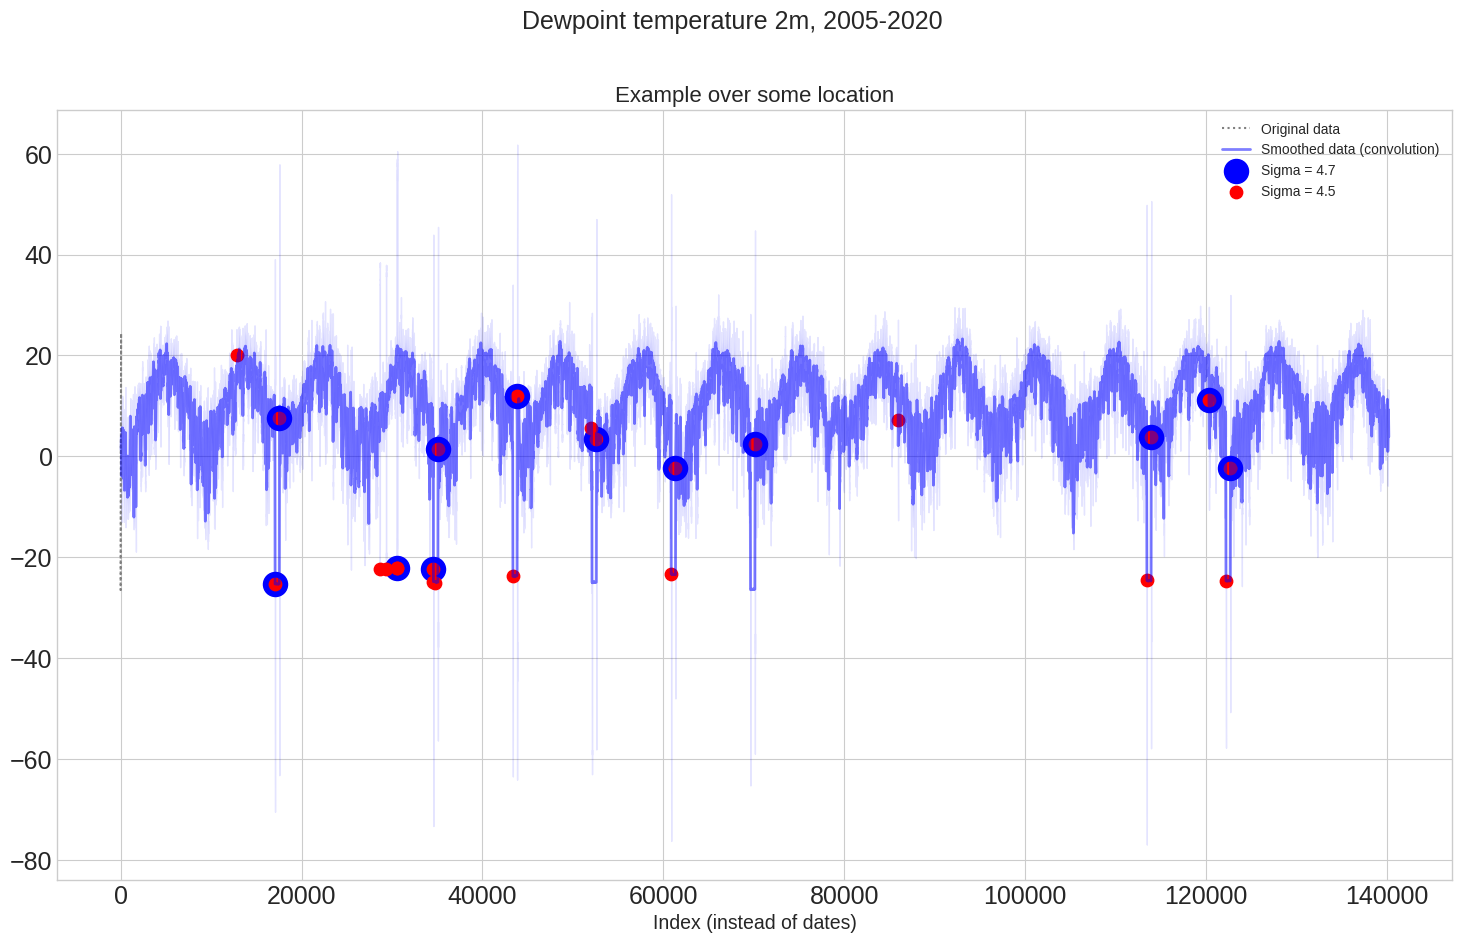

In [29]:
fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i, ax in enumerate(axes):
    
    # plot original time series
    # ax.plot(
    #     series['original'][i,1:],
    #     '.k',
    #     label='Original data',
    #     ms='2',
    # )
    
    ax.plot(
        series['original'][i,1:],
        series['original'][i,1:],  #'.k',
        color='grey',
        linestyle='dotted',
        label='Original data',
        ms='80',
    )
    
    # build + plot "positional" (?) range
    posrange = np.arange(window_len,timesteps)
    ax.plot(
        posrange,
        series['smooth'][i,1:],
        c='blue',
        alpha=0.5,
        linewidth=2,
        label='Smoothed data (convolution)',
    )
    ax.fill_between(
        posrange, 
        series['low'][i,1:],
        series['up'][i,1:], 
        color='blue',
        alpha=0.1
    )

    ano_id_2 = series['ano_id_2'][i][series['ano_id_2'][i] != 0] -1
    if len(ano_id)>0:
        ax.scatter(
            ano_id_2,
            series['original'][i,1:][ano_id_2],
            c='blue',
            alpha=1.,
            label=f'Sigma = {n_sigma_2}',
            s=300,
        )

    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    if len(ano_id)>0:
        ax.scatter(
            ano_id,
            series['original'][i,1:][ano_id],
            # marker='d',
            c='red',
            alpha=1.,
            label=f'Sigma = {n_sigma}',
            s=80,
        )


plt.suptitle('Dewpoint temperature 2m, 2005-2020', fontsize=18)
plt.title('Example over some location', fontsize=16)
# plt.ylabel(fontsize=14)
plt.xlabel('Index (instead of dates)', fontsize=14)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=18)
plt.legend()
plt.show()

### Wind speed

#### Sliding window and Sigma parameters

In [30]:
window_len = 24
n_sigma = 4
n_sigma_2 = 4.5
print(f'Window length : {window_len}\nn_sigma : {n_sigma}\nn_sigma_2 : {n_sigma_2}')

Window length : 24
n_sigma : 4
n_sigma_2 : 4.5


#### Prepare data

The input data set is:

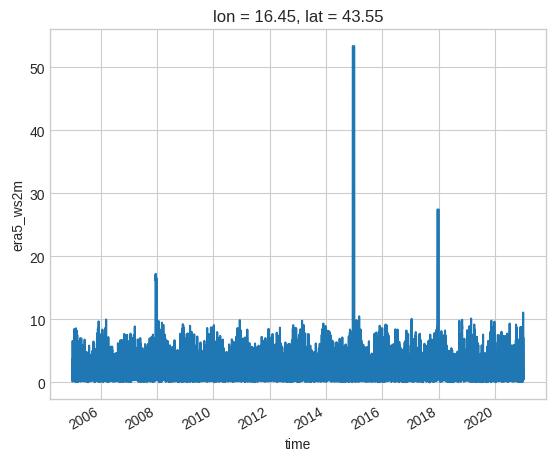

In [31]:
plt.title('Wind speed')
# plt.ylabel('')
ws_location_3.plot()
np.set_printoptions(False)
plt.show()

This time series obviously contains two erroneous data points, likely artefacts introduced during the patching process of ERA5 and ERA5-Land data.

In order to make the data work with the `tsmoothie` package, we convert the xarray to a regular NumPy array.

In [32]:
n_series = 1
timesteps = ws_location_3.time.size
ws_location_3_array = ws_location_3.to_numpy().reshape(1, timesteps)
data = np.array(ws_location_3_array, copy=True)

print(f'Shape of array : {data.shape}\nNumber of time series : {n_series}\nTime steps : {timesteps}')

Shape of array : (1, 140256)
Number of time series : 1
Time steps : 140256


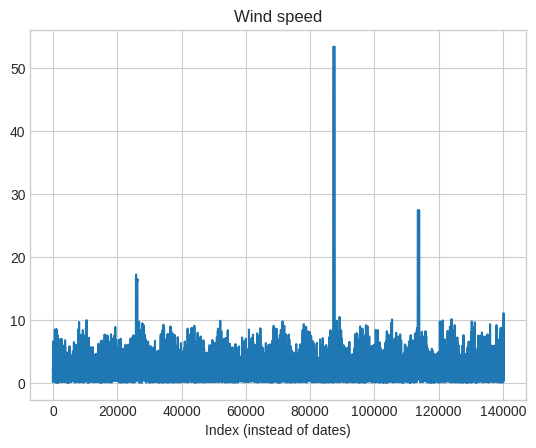

In [33]:
plt.title('Wind speed')
# plt.ylabel('')
plt.xlabel('Index (instead of dates)')
plt.plot(data.T)
np.set_printoptions(False)
plt.show()

#### Detect outliers

In [34]:
# This is to create a GIF!

# fig = plt.figure(figsize=(18,10))
# camera = Camera(fig)
# axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

In [35]:
%%time
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))
for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i > window_len:
    
        # smooth time series first ?
        smoother = ConvolutionSmoother(window_len=window_len, window_type='ones')
        smoother.smooth(series['original'][:,-window_len:])
        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        # 1
        
        # split in upper and lower stacks based on smoothed series and 'n_sigma'
        _low, _up = smoother.get_intervals(
            'sigma_interval',
            n_sigma=n_sigma
        )
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])
        
        # detect anomalies
        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack(
                [series['ano_id'],
                 is_anomaly*i]
            ).astype(int)
            
        
        # 2
        
        # split in upper and lower stacks based on smoothed series and 'n_sigma_2'
        _low_2, _up_2 = smoother.get_intervals(
            'sigma_interval',
            n_sigma=n_sigma_2
        )
        series['low_2'] = np.hstack([series['low_2'], _low_2[:,[-1]]])
        series['up_2'] = np.hstack([series['up_2'], _up_2[:,[-1]]])

        # detect anomalies
        is_anomaly_2 = np.logical_or(
            series['original'][:,-1] > series['up_2'][:,-1], 
            series['original'][:,-1] < series['low_2'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly_2.any():
            series['ano_id_2'] = np.hstack(
                [series['ano_id_2'],
                 is_anomaly_2*i]
            ).astype(int)
        
        # for s in range(n_series):
        #     pltargs = {k:v[s,:] for k,v in series.items()}
        #     plot_history(axes[s], i, is_anomaly[s], window_len, 
        #                  **pltargs)
        # camera.snap()
        
    if i >= timesteps:
        continue
    
    series['original'] = np.hstack(
        [series['original'],
         data[:,[i]]]
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140257/140257 [01:51<00:00, 1257.69it/s]

CPU times: user 1min 51s, sys: 200 ms, total: 1min 51s
Wall time: 1min 51s


In [36]:
# print('CREATING GIF...')  # it may take a few seconds
# camera._photos = [camera._photos[-1]] + camera._photos
# animation = camera.animate()
# animation.save('animation1.gif')
# plt.close(fig)
# print('DONE')

#### Result

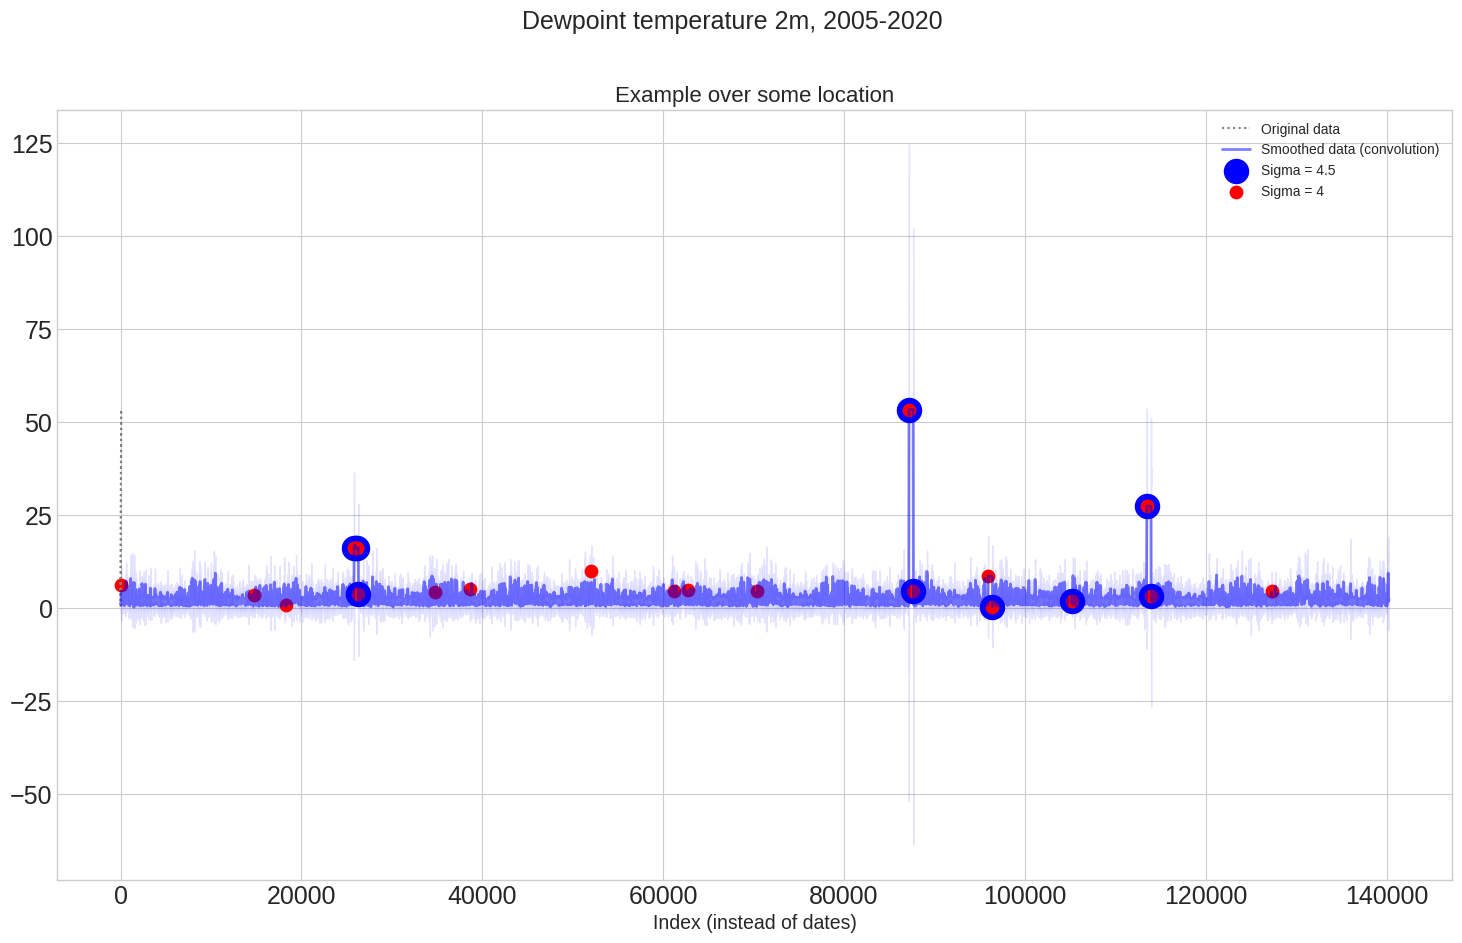

In [37]:
fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i, ax in enumerate(axes):
    
    # plot original time series
    # ax.plot(
    #     series['original'][i,1:],
    #     '.k',
    #     label='Original data',
    #     ms='2',
    # )
    
    ax.plot(
        series['original'][i,1:],
        series['original'][i,1:],  #'.k',
        color='grey',
        linestyle='dotted',
        label='Original data',
        ms='80',
    )
    
    # build + plot "positional" (?) range
    posrange = np.arange(window_len,timesteps)
    ax.plot(
        posrange,
        series['smooth'][i,1:],
        c='blue',
        alpha=0.5,
        linewidth=2,
        label='Smoothed data (convolution)',
    )
    ax.fill_between(
        posrange, 
        series['low'][i,1:],
        series['up'][i,1:], 
        color='blue',
        alpha=0.1
    )

    ano_id_2 = series['ano_id_2'][i][series['ano_id_2'][i] != 0] -1
    if len(ano_id_2)>0:
        ax.scatter(
            ano_id_2,
            series['original'][i,1:][ano_id_2],
            c='blue',
            alpha=1.,
            label=f'Sigma = {n_sigma_2}',
            s=300,
        )

    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    if len(ano_id)>0:
        ax.scatter(
            ano_id,
            series['original'][i,1:][ano_id],
            # marker='d',
            c='red',
            alpha=1.,
            label=f'Sigma = {n_sigma}',
            s=80,
        )


plt.suptitle('Dewpoint temperature 2m, 2005-2020', fontsize=18)
plt.title('Example over some location', fontsize=16)
# plt.ylabel(fontsize=14)
plt.xlabel('Index (instead of dates)', fontsize=14)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=18)
plt.legend()
plt.show()

#### Get the dates for the detected outliers!

..

## Exponential smoother

### Temperature 2m

#### Sliding window and Sigma parameters

In [38]:
window_len = 24
n_sigma = 1
n_sigma_2 = 10
print(f'Window length : {window_len}\nn_sigma : {n_sigma}\nn_sigma_2 : {n_sigma_2}')

Window length : 24
n_sigma : 1
n_sigma_2 : 10


#### Prepare data

This time series obviously contains two erroneous data points, likely artefacts introduced during the patching process of ERA5 and ERA5-Land data.

In order to make the data work with the `tsmoothie` package, we convert the xarray to a regular NumPy array.

In [39]:
n_series = 1
timesteps = t2m_some_location.size
t2m_some_location_array = t2m_some_location.to_numpy().reshape(n_series, timesteps)
data = np.array(t2m_some_location_array, copy=True)

print(f'Shape of array : {data.shape}\nNumber of time series : {n_series}\nTime steps : {timesteps}')

Shape of array : (1, 140256)
Number of time series : 1
Time steps : 140256


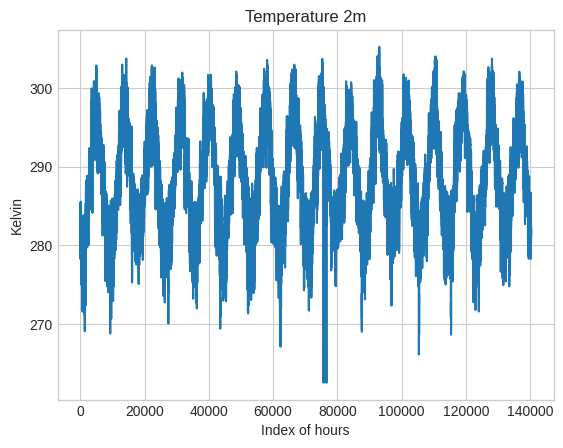

In [40]:
plt.title('Temperature 2m')
plt.ylabel('Kelvin')
plt.xlabel('Index of hours')
plt.plot(data.T)
np.set_printoptions(False)
plt.show()

#### Detect outliers

In [41]:
### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###

# fig = plt.figure(figsize=(18,10))
# camera = Camera(fig)

# axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

In [42]:
%%time

series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
        smoother = ExponentialSmoother(window_len=window_len//2, alpha=0.4)
        smoother.smooth(series['original'][:,-window_len:])
        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        # 1
        
        # split in upper and lower stacks based on smoothed series and 'n_sigma'
        
        _low, _up = smoother.get_intervals(
            'sigma_interval',
            n_sigma=n_sigma
        )
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack(
                [series['ano_id'],
                 is_anomaly*i]
            ).astype(int)
            
        # 2
        
        # split in upper and lower stacks based on smoothed series and 'n_sigma_2'
        _low_2, _up_2 = smoother.get_intervals(
            'sigma_interval',
            n_sigma=n_sigma_2
        )
        series['low_2'] = np.hstack([series['low_2'], _low_2[:,[-1]]])
        series['up_2'] = np.hstack([series['up_2'], _up_2[:,[-1]]])

        # detect anomalies
        is_anomaly_2 = np.logical_or(
            series['original'][:,-1] > series['up_2'][:,-1], 
            series['original'][:,-1] < series['low_2'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly_2.any():
            series['ano_id_2'] = np.hstack(
                [series['ano_id_2'],
                 is_anomaly_2*i]
            ).astype(int)
        # for s in range(n_series):
        #     pltargs = {k:v[s,:] for k,v in series.items()}
        #     plot_history(axes[s], i, is_anomaly[s], window_len, 
        #                  **pltargs)

        # camera.snap()
    
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], data[:,[i]]])
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140257/140257 [01:41<00:00, 1386.12it/s]

CPU times: user 1min 41s, sys: 200 ms, total: 1min 41s
Wall time: 1min 41s


In [43]:
# print('CREATING GIF...')  # it may take a few seconds
# camera._photos = [camera._photos[-1]] + camera._photos
# animation = camera.animate()
# animation.save('animation2.gif')
# plt.close(fig)
# print('DONE')

#### Result

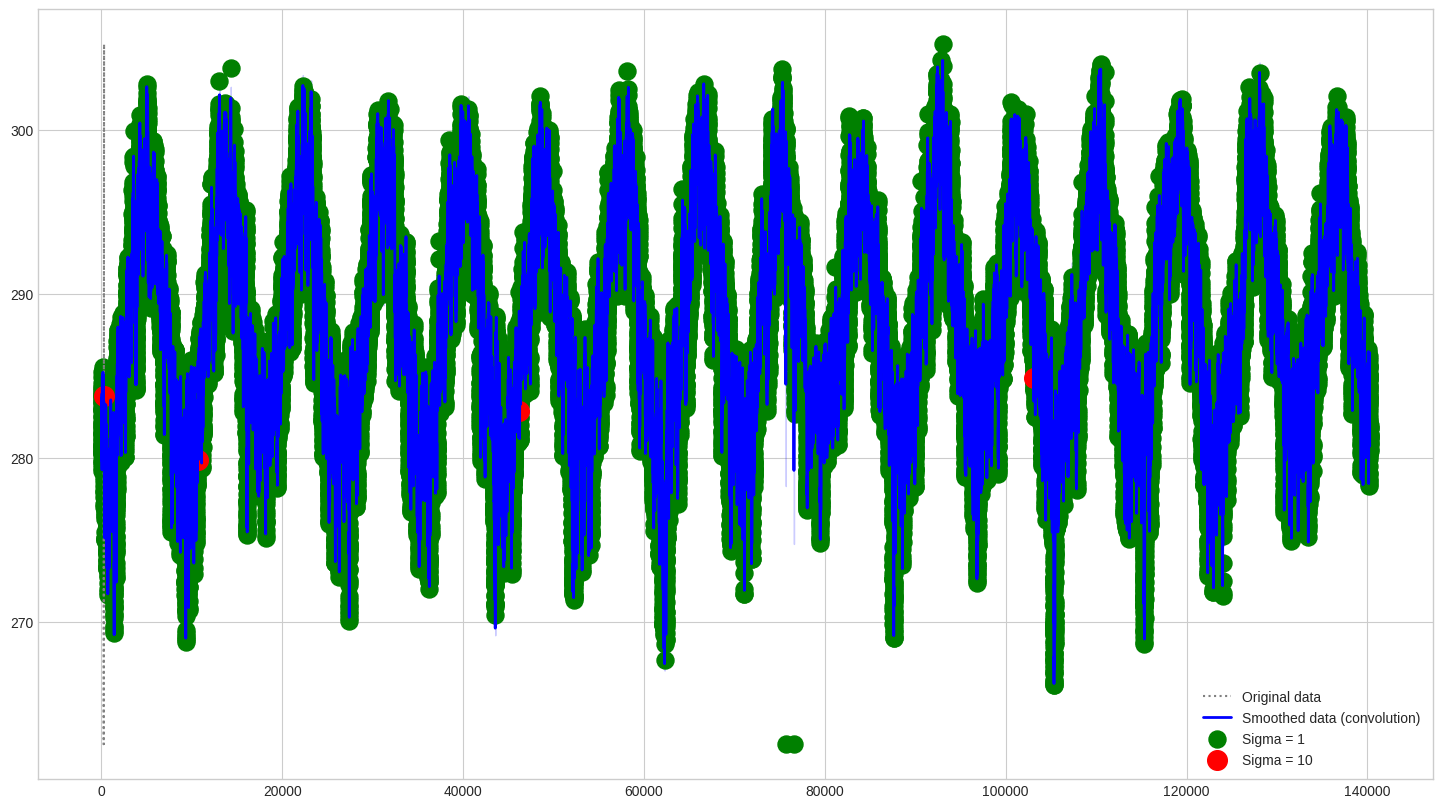

In [44]:
fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i, ax in enumerate(axes):
    
    # plot original time series
    # ax.plot(
    #     series['original'][i,1:],
    #     '.k',
    #     label='Original data',
    #     ms='2',
    # )
    ax.plot(
        series['original'][i,1:],
        series['original'][i,1:],  #'.k',
        color='grey',
        linestyle='dotted',
        label='Original data',
        ms='80',
    )
    
    # build + plot "positional" (?) range
    posrange = np.arange(window_len,timesteps)
    ax.plot(
        posrange,
        series['smooth'][i,1:],
        c='blue',
        linewidth=2,
        label='Smoothed data (convolution)',
    )
    ax.fill_between(
        posrange, 
        series['low'][i,1:],
        series['up'][i,1:], 
        color='blue',
        alpha=0.2
    )

    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    if len(ano_id)>0:
        ax.scatter(
            ano_id,
            series['original'][i,1:][ano_id],
            c='green',
            alpha=1.,
            label=f'Sigma = {n_sigma}',
            s=150,
        )

    ano_id_2 = series['ano_id_2'][i][series['ano_id_2'][i] != 0] -1
    if len(ano_id)>0:
        ax.scatter(
            ano_id_2,
            series['original'][i,1:][ano_id_2],
            c='red',
            alpha=1.,
            label=f'Sigma = {n_sigma_2}',
            s=200,
        )

plt.legend()

## Seasonal-Trend-Decomposition

### Temperature 2m

:::{warning}
This approach is time consuming!
:::

#### Sliding window parameter

In [59]:
window_len = 24*8

#### Prepare data

In [64]:
n_series = 1
timesteps = t2m_some_location.size
t2m_some_location_array = t2m_some_location.to_numpy().reshape(n_series, timesteps)
data = np.array(t2m_some_location_array, copy=True)
data[:,500:800] = data[:,500:800] + 20

print(f'Shape of array : {data.shape}\nNumber of time series : {n_series}\nTime steps : {timesteps}')

Shape of array : (1, 140256)
Number of time series : 1
Time steps : 140256


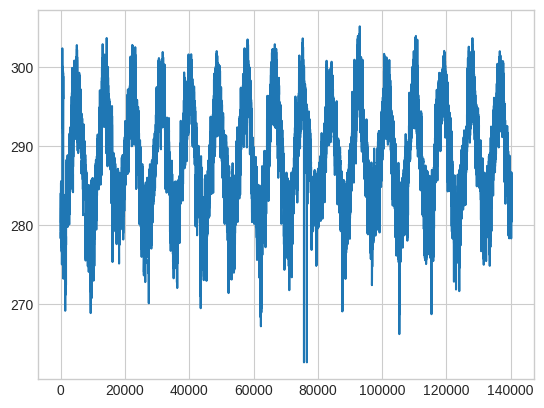

In [65]:
plt.plot(data.T)
np.set_printoptions(False)

#### Detect outliers

In [66]:
### SIMULATE PROCESS REAL-TIME AND CREATE GIF ###

# fig = plt.figure(figsize=(18,10))
# camera = Camera(fig)

# axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

In [67]:
series = defaultdict(partial(np.ndarray, shape=(n_series,1), dtype='float32'))

for i in tqdm(range(timesteps+1), total=(timesteps+1)):
    
    if i>window_len:
    
        smoother = DecomposeSmoother(smooth_type='convolution', periods=24,
                                     window_len=window_len//3, window_type='ones')
        smoother.smooth(series['original'][:,-window_len:])

        series['smooth'] = np.hstack([series['smooth'], smoother.smooth_data[:,[-1]]]) 

        _low, _up = smoother.get_intervals('sigma_interval', n_sigma=2.5)
        series['low'] = np.hstack([series['low'], _low[:,[-1]]])
        series['up'] = np.hstack([series['up'], _up[:,[-1]]])

        is_anomaly = np.logical_or(
            series['original'][:,-1] > series['up'][:,-1], 
            series['original'][:,-1] < series['low'][:,-1]
        ).reshape(-1,1)
        
        if is_anomaly.any():
            series['ano_id'] = np.hstack([series['ano_id'], is_anomaly*i]).astype(int)
            
        for s in range(n_series):
            pltargs = {k:v[s,:] for k,v in series.items()}
            plot_history(axes[s], i, is_anomaly[s], window_len, 
                         **pltargs)

        # camera.snap()
        
    if i>=timesteps:
        continue
    
    series['original'] = np.hstack([series['original'], data[:,[i]]])
    

# print('CREATING GIF...')  # it may take a few seconds
# camera._photos = [camera._photos[-1]] + camera._photos
# animation = camera.animate()
# animation.save('animation3.gif')
# plt.close(fig)
# print('DONE')

  7%|████████▉                                                                                                                     | 9976/140257 [1:04:49<14:06:39,  2.56it/s]


KeyboardInterrupt: 

#### Result

In [ ]:
fig = plt.figure(figsize=(18,10))
axes = [plt.subplot(n_series,1,ax+1) for ax in range(n_series)]

for i,ax in enumerate(axes):
    
    posrange = np.arange(window_len,timesteps)
    
    ax.plot(series['original'][i,1:], '.k')
    ax.plot(posrange, series['smooth'][i,1:], c='blue', linewidth=3)
    
    ax.fill_between(posrange, 
                    series['low'][i,1:], series['up'][i,1:], 
                    color='blue', alpha=0.2)
    
    ano_id = series['ano_id'][i][series['ano_id'][i] != 0] -1
    
    if len(ano_id)>0:
        ax.scatter(ano_id, series['original'][i,1:][ano_id], 
                   c='red', alpha=1.)